# Measure of Bias and Variance – An Experiment

Known Facts:
* Linear Regression - low variance and high bias
* Classification Algorithms - high variance and low bias
* Experiment: To realize the above statements using "Protein Tertiary Structure" Data Set.
* Data : https://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure

In [8]:
# Loading the required libraries
import pickle
import sys
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image

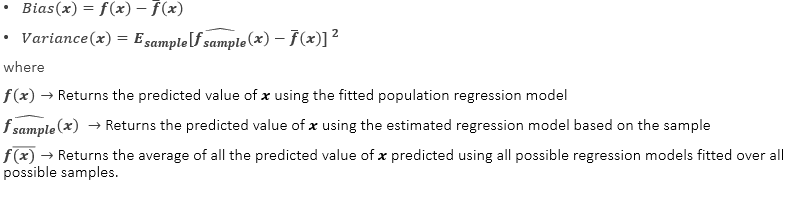

In [ ]:
Image("biasVariance.PNG")

Variance and Bias are explained in the figure above. Have followed this context of Bias and Variance with this experiment.
So, in order to accomplish the above, the given data is considered as population.
Note: The performace of the algorithms are not with the scope of this experiment. Purely to calculate the Bias and Variance.

In [9]:
# Loading population data : Based on our assumption, the entire dataset is considered as population data
population_data= pd.read_csv(r"https://drive.google.com/uc?id=1-4nWuRu_X8q9PA3DzSSW9CdfP_4etFK0&export=download")

In [3]:
population_data.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


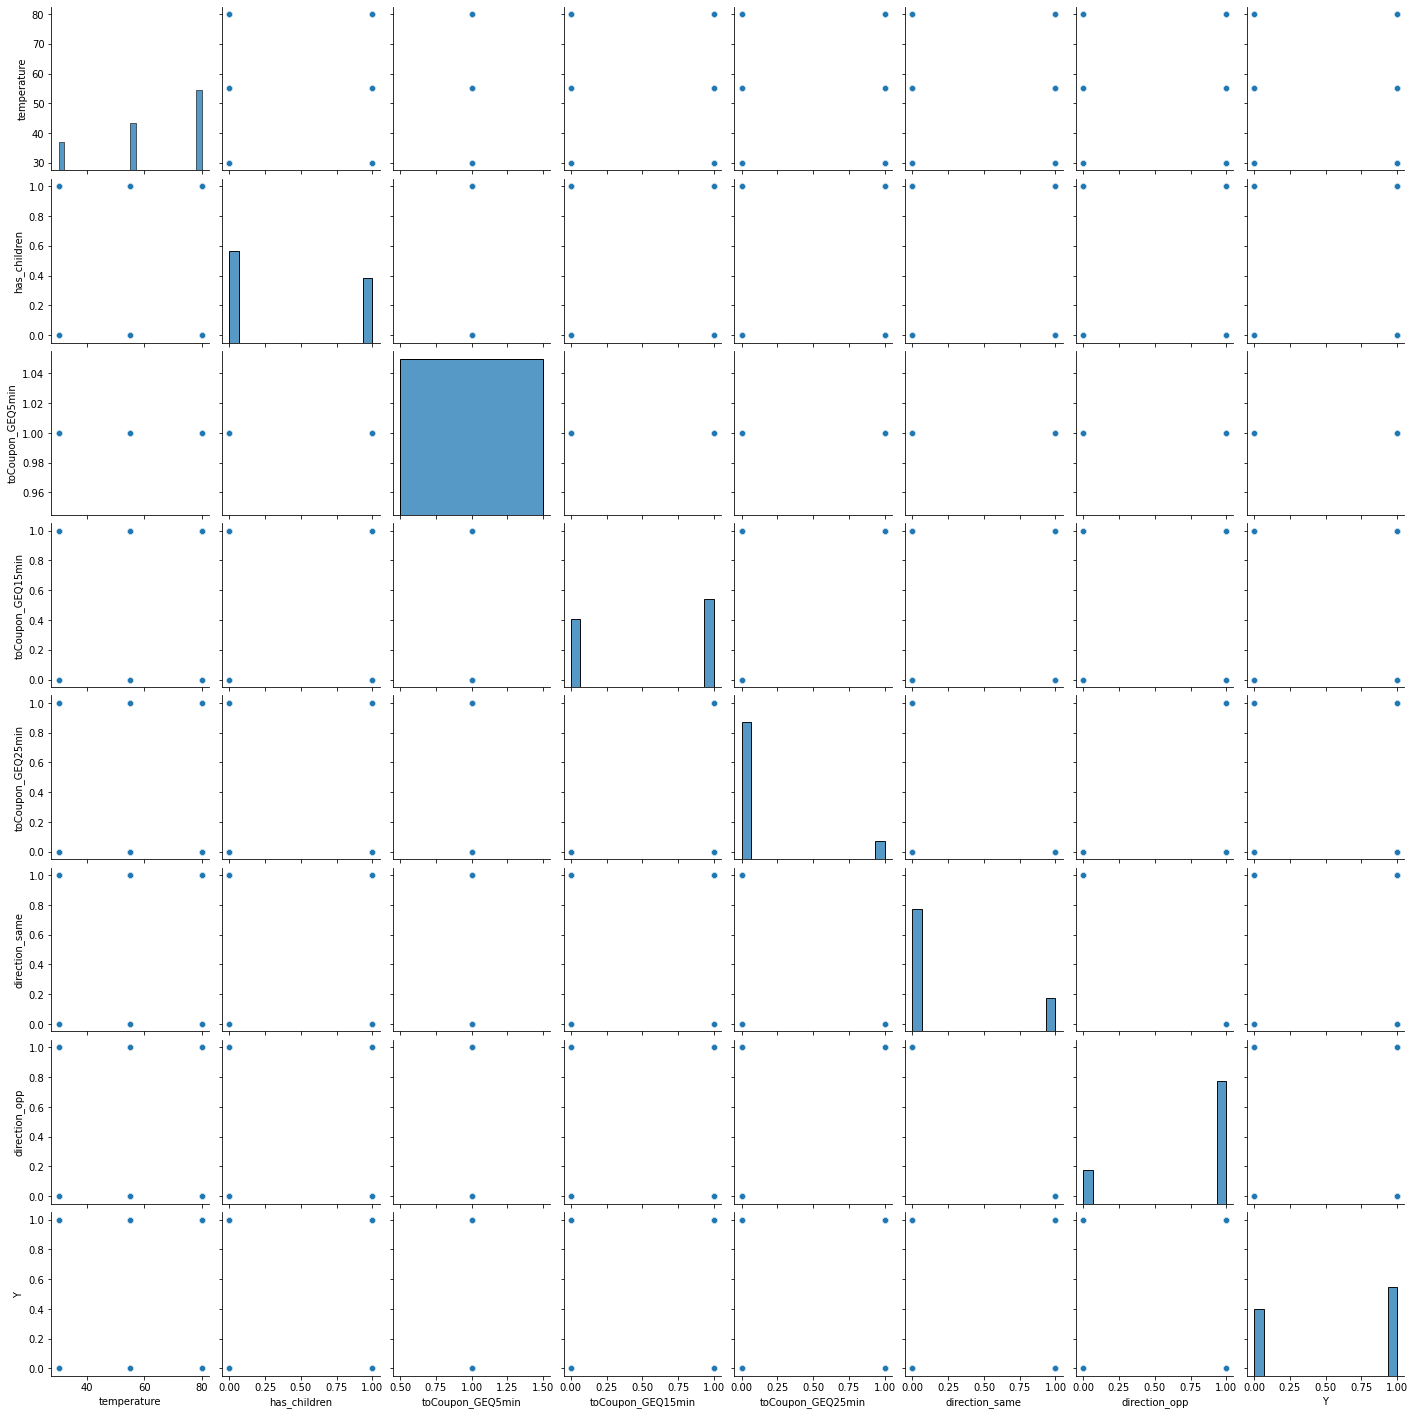

In [10]:
# Plotting the pair plot to get an idea of which variable could be considered as a target variable
sns.pairplot(population_data)

In [11]:
population_data.columns
# F9 is being considered as the dependent variable

Index(['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse',
       'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Y'],
      dtype='object')

## Data Information : 
### Abstract: 
This is a data set of Physicochemical Properties of Protein Tertiary Structure. The data set is taken from CASP 5-9. There are 45730 decoys and size varying from 0 to 21 armstrong.

### Variable information:
RMSD-Size of the residue.
* F1 - Total surface area.
* F2 - Non polar exposed area.
* F3 - Fractional area of exposed non polar residue.
* F4 - Fractional area of exposed non polar part of residue.
* F5 - Molecular mass weighted exposed area.
* F6 - Average deviation from standard exposed area of residue.
* F7 - Euclidian distance.
* F8 - Secondary structure penalty.
* F9 - Spacial Distribution constraints (N,K Value).

In [12]:
population_data.shape
# so, our population has 45730 no of records

(12684, 26)

In [13]:
#Creamos el método de pre-procesamiento aplicando criterios del paper [6] y lo aprendido en clase en el caso Titanic.
def preprocess_dataset(dataset, save_metadata=True):
  preprocessed_dataset = dataset.copy()
  
  #Eliminamos la variable "toCoupon_GEQ5min"
  preprocessed_dataset.drop("toCoupon_GEQ5min", axis=1, inplace=True)

  #Eliminamos la variable "direction_same"
  preprocessed_dataset.drop("direction_same", axis=1, inplace=True)

  #Determinamos aquellas variables que tengan un porcentaje de registros nulos por cada variable mayor al valor de 0.7
  threshold = 0.7
  null_percentages = preprocessed_dataset.isna().sum() / len(preprocessed_dataset)
  criteria = null_percentages > threshold
  columns_to_filter = null_percentages[criteria].keys()

  #Eliminamos las variables seleccionadas en el paso anterior
  preprocessed_dataset.drop(columns_to_filter, axis=1, inplace=True)

  #Eliminamos los registros duplicados
  preprocessed_dataset.drop_duplicates(keep="first", inplace=True)

  #Determinamos que variables son del tipo númerico y cuales son categóricas
  numeric_columns = list()
  categorical_columns = list()
  dictionary_of_columns_with_index_to_categorical = dict()
  dictionary_of_columns_with_categorical_to_index = dict()

  for column in preprocessed_dataset:
      #Determinamos si la variable es numérica o no
      if pd.api.types.is_numeric_dtype(preprocessed_dataset[column]):
        numeric_columns.append(column)
      else:
        #Modificamos el tipo de dato de la variable mediante "astype"
        preprocessed_dataset[column] = preprocessed_dataset[column].astype("category")

        #Verificamos si el tipo de dato de la variable fue transformado a categórico correctamente
        if not pd.api.types.is_categorical_dtype(preprocessed_dataset[column]):
          raise Exception("La columna {} no se transformó correctamente a categórica".format(column))

        dictionary_of_columns_with_index_to_categorical[column] = dict()
        dictionary_of_columns_with_categorical_to_index[column] = dict()
        
        #Indexamos los valores (categorías), sin tomar en consideración los nulos, de la variable y guardamos esa información en los diccionarios
        for index, category in enumerate(preprocessed_dataset[column].cat.categories):
          dictionary_of_columns_with_index_to_categorical[column][index] = category
          dictionary_of_columns_with_categorical_to_index[column][category] = index
        
        categorical_columns.append(column)
    
  #Reemplazamos los nulos con la mediana sólo de aquellas variables numéricas
  median_of_numeric_columns = preprocessed_dataset[numeric_columns].median()

  preprocessed_dataset[numeric_columns] = preprocessed_dataset[numeric_columns].fillna(median_of_numeric_columns)

  #Transformamos a números los valores (categorías) de las variables categóricas sin considerar los nulos
  preprocessed_dataset.replace(dictionary_of_columns_with_categorical_to_index, inplace=True)

  #Generamos una nueva lista de variables categóricas y las variables eliminadas por tener un porcentaje alto de registros nulos
  categorical_columns_filtered = categorical_columns[:]
  
  if len(categorical_columns_filtered) > 0:
    #Reemplazamos los nulos con la mediana para todas las variables y las variables eliminadas por tener un porcentaje alto de registros nulos
    median_of_categorical_columns = preprocessed_dataset[categorical_columns_filtered].median()

    preprocessed_dataset[categorical_columns_filtered] = preprocessed_dataset[categorical_columns_filtered].fillna(median_of_categorical_columns)
  
  if save_metadata:
    #Guardamos información que consideremos imporante. El formato pickle nos permite guardar objetos de python
    with open("numeric_columns.pkl", "wb") as f:
      pickle.dump(numeric_columns, f)
    
    with open("categorical_columns.pkl", "wb") as f:
      pickle.dump(categorical_columns, f)
    
    with open("dictionary_of_columns_with_index_to_categorical.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_index_to_categorical, f)
    
    with open("dictionary_of_columns_with_categorical_to_index.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_categorical_to_index, f)
      
  return preprocessed_dataset

In [14]:
preprocessed_dataset = preprocess_dataset(population_data)

In [16]:
preprocessed_dataset.shape

(12610, 23)

In [17]:
#Separamos la data, en variables independientes (x) y dependientes (y), para poder entrenar nuestro modelo.
#x = preprocessed_dataset.drop("Y", axis=1)

#y = preprocessed_dataset["Y"]

In [18]:
#from sklearn.model_selection import train_test_split
#Mediante el método "train_test_split" usaremos el 20% de la data para probar el modelo. 
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [25]:
# Extracting the test data, on which the prediction is to be made and the corresponding variance 
# and bias calculation is made. No of records for test data - 300
test_data = preprocessed_dataset.sample(int(len(preprocessed_dataset)*0.20), replace= False, random_state=100) 
# Test data should be part of the training data and reindexing it.
train_data = preprocessed_dataset.drop(test_data.index, axis=0).reindex()
# Reindexing the test data
test_data = test_data.reindex()

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
###################### Building population models ###############################################
# Separating the test and train variables
X_train = preprocessed_dataset.drop(['Y'], axis=1)
y_train = preprocessed_dataset['Y']
X_test = test_data.drop(['Y'], axis=1)
y_test = test_data['Y']

###################### Linear Regression #########################################################
# Note: The population data is inclusive of both test and train data
# Building a linear model on population data
population_decision_tree = DecisionTreeClassifier(max_depth= 9, max_features= 16).fit(X_train, y_train)
y_hat_pop_tree = population_decision_tree.predict(X_test)

###################### Decision Tree #############################################################
# Building a Decision tree model on population data and obtaining predicion on test data
population_knn = KNeighborsClassifier(n_neighbors=50).fit(X_train, y_train)
y_hat_knn = population_knn.predict(X_test)

###################### Bagging - Decision Tree ###################################################
# Building a Bagging model on population data and obtaining predicion on test data
population_randomForest_model = RandomForestClassifier(bootstrap=False,criterion='gini',max_depth=200,
           min_samples_leaf=1,min_samples_split=5,n_estimators=2152).fit(X_train, y_train)
y_hat_pop_randomForest = population_randomForest_model.predict(X_test)


###################### Random Forest ###################################################
# Building a Random Forest model on population data and obtaining predicion on test data
population_xgboost_model = XGBClassifier(colsample_bytree= 0.6433202217694323, learning_rate = 
                      0.1651701279540872, max_depth = 8, min_child_weight = 1, 
                      n_estimators = 213, subsample = 0.8974166008989073).fit(X_train, y_train)
y_hat_pop_xgboost = population_xgboost_model.predict(X_test)

population_logistic_model = LogisticRegression(C= 100, penalty='l2', solver='newton-cg').fit(X_train, y_train)
y_hat_pop_logistic = population_logistic_model.predict(X_test)

population_svm_model = SVC(C=3.1623, gamma=0.1000, kernel='rbf', probability=True).fit(X_train, y_train)
y_hat_pop_svm = population_svm_model.predict(X_test)

In [31]:
# Method to compute the variance
def calculate_varaince_of_model(samplePredictions, y_test):
    predictions_mean_model = samplePredictions.mean(axis =1)
    colNames = samplePredictions.columns
    variance = np.zeros(len(colNames))
    i = 0
    for colName in colNames:
        variance[i] = np.mean(np.square(samplePredictions[colName] - predictions_mean_model))
        rmse = mean_squared_error(y_test, samplePredictions[colName])
        i += 1
    return round(np.mean(variance),3), round(np.mean(rmse),3)

In [32]:
# Method to compute the bias
def calculate_bias_of_model(samplePredictions, y_hat_pop):
    return np.square((np.abs(samplePredictions.mean(axis=1) -y_hat_pop).mean()))

In [33]:
# Note : Care has to be taken such that X_test should be a value, as per the previous block of codes

def samplePredForDecisionTree(X_train, y_train):
    sample_Tree_Model = DecisionTreeClassifier(max_depth= 9, max_features= 16).fit(X_train, y_train)
    return sample_Tree_Model.predict(X_test)

# Method to build linear moodel, gives, predictions as an output.
def samplePredForKNN(X_train, y_train):
    sample_knn_Model = KNeighborsClassifier(n_neighbors=50).fit(X_train, y_train)
    return sample_knn_Model.predict(X_test)
    
# Method to build Decision tree bagging model
def samplePredForRandomForest(X_train, y_train):
    sample_RandomForest_Model = RandomForestClassifier(bootstrap=False,criterion='gini',max_depth=200,
           min_samples_leaf=1,min_samples_split=5,n_estimators=2152).fit(X_train, y_train)
    return sample_RandomForest_Model.predict(X_test)

# Method to build Random Forst model
def samplePredForXGBoost(X_train, y_train):
    sample_XGBoost_Model = XGBClassifier(colsample_bytree= 0.6433202217694323, learning_rate = 
                      0.1651701279540872, max_depth = 8, min_child_weight = 1, 
                      n_estimators = 213, subsample = 0.8974166008989073).fit(X_train, y_train)
    return sample_XGBoost_Model.predict(X_test)

def samplePredForLogisticRegression(X_train, y_train):
    sample_LogisticRegression_Model = LogisticRegression(C= 100, penalty='l2', solver='newton-cg').fit(X_train, y_train)
    return sample_LogisticRegression_Model.predict(X_test)

def samplePredForSVM(X_train, y_train):
    sample_SVM_Model = SVC(C=3.1623, gamma=0.1000, kernel='rbf', probability=True).fit(X_train, y_train)
    return sample_SVM_Model.predict(X_test)


In [36]:
# it is the main method, which computes the bias and variance of various model
# Takes sampleCount - sample size and noOfModels - no of models that are to be built i.e. the no of times the samples are to
# be obtained from the population
def get_bias_variance(sampleCount, noOfModels):
    bias_variance_result = pd.DataFrame(columns=['sample_count','no_of_models','algorithm','bias','variance', 'mse'])
    print('Builds Linear Regression, Decision Tree, Bagging, Random Forest algorithms')
    print('Total No of models built is',str(noOfModels* 4))
    
    samplePredictionsTree = pd.DataFrame()
    samplePredictionsKNN = pd.DataFrame()
    samplePredictionsRandomForest = pd.DataFrame()
    samplePredictionsXGBoost = pd.DataFrame()
    samplePredictionsLogisticRegression = pd.DataFrame()
    samplePredictionsSVM = pd.DataFrame()
    
    with tqdm.tqdm(total=noOfModels, file=sys.stdout) as pbar:
        for i in range(0, noOfModels):
            pbar.set_description('Building Model : %d' % (1 + i))
            sample = train_data.sample(sampleCount,replace=False)
            X_train = sample.drop(['Y'], axis=1)
            y_train = sample['Y']

            samplePredictionsTree['sample'+str(i+1)] = samplePredForDecisionTree(X_train, y_train)
            samplePredictionsKNN['sample'+str(i+1)] = samplePredForKNN(X_train, y_train)
            samplePredictionsRandomForest['sample'+str(i+1)] = samplePredForRandomForest(X_train, y_train)
            samplePredictionsXGBoost['sample'+str(i+1)] = samplePredForXGBoost(X_train, y_train)
            samplePredictionsLogisticRegression['sample'+str(i+1)] = samplePredForLogisticRegression(X_train, y_train)
            samplePredictionsSVM['sample'+str(i+1)] = samplePredForSVM(X_train, y_train)
            pbar.update(1)
    
    '''print('samplePredictionsLinearModel :', samplePredictionsLinearModel.shape)
    print('samplePredictionsTree :', samplePredictionsTree.shape)
    print('samplePredictionsBagging :', samplePredictionsBagging.shape)
    print('samplePredictionsRandomForest :', samplePredictionsRandomForest.shape)'''
    
    var_mse_tree_model = calculate_varaince_of_model(samplePredictionsTree, y_test)
    var_mse_knn_model = calculate_varaince_of_model(samplePredictionsKNN, y_test)
    var_mse_random_forest_model = calculate_varaince_of_model(samplePredictionsRandomForest, y_test)
    var_mse_xgboost_model = calculate_varaince_of_model(samplePredictionsXGBoost, y_test)
    var_mse_logistic_regression_model = calculate_varaince_of_model(samplePredictionsLogisticRegression, y_test)
    var_mse_svm_model = calculate_varaince_of_model(samplePredictionsSVM, y_test)
    
    bias_tree_model = calculate_bias_of_model(samplePredictionsTree, y_hat_pop_tree)
    bias_knn_model = calculate_bias_of_model(samplePredictionsKNN, y_hat_knn)
    bias_random_forest_model = calculate_bias_of_model(samplePredictionsRandomForest, y_hat_pop_randomForest)
    bias_random_xgboost_model = calculate_bias_of_model(samplePredictionsXGBoost, y_hat_pop_xgboost)
    bias_random_logistic_regression_model = calculate_bias_of_model(samplePredictionsLogisticRegression, y_hat_pop_logistic)
    bias_random_svm_model = calculate_bias_of_model(samplePredictionsSVM, y_hat_pop_svm)
    
    s_tree = pd.Series(data={'sample_count':sampleCount, 'no_of_models':noOfModels, 'algorithm':'Decision Tree',
                    'bias':bias_tree_model, 'variance' : var_mse_tree_model[0], 'mse' : var_mse_tree_model[1]}, name = 0)
    
    s_knn = pd.Series(data={'sample_count':sampleCount, 'no_of_models':noOfModels, 'algorithm':'KNN',
                    'bias':bias_knn_model, 'variance' : var_mse_knn_model[0], 'mse' : var_mse_knn_model[1]}, name = 0)
    
    s_rf = pd.Series(data={'sample_count':sampleCount, 'no_of_models':noOfModels, 'algorithm':'Random Forest',
                    'bias':bias_random_forest_model, 'variance' : var_mse_random_forest_model[0], 'mse' : var_mse_random_forest_model[1]}, name = 0)
    
    s_xgb = pd.Series(data={'sample_count':sampleCount, 'no_of_models':noOfModels, 'algorithm':'XGBoost',
                    'bias':bias_random_xgboost_model, 'variance' : var_mse_xgboost_model[0], 'mse' : var_mse_xgboost_model[1]}, name = 0)

    s_lr = pd.Series(data={'sample_count':sampleCount, 'no_of_models':noOfModels, 'algorithm':'LogisticRegression',
                    'bias':bias_random_logistic_regression_model, 'variance' : var_mse_logistic_regression_model[0], 'mse' : var_mse_logistic_regression_model[1]}, name = 0)

    s_svm = pd.Series(data={'sample_count':sampleCount, 'no_of_models':noOfModels, 'algorithm':'SVM',
                    'bias':bias_random_svm_model, 'variance' : var_mse_svm_model[0], 'mse' : var_mse_svm_model[1]}, name = 0)
    
    bias_variance_result = bias_variance_result.append(s_tree)
    bias_variance_result = bias_variance_result.append(s_knn)
    bias_variance_result = bias_variance_result.append(s_rf)
    bias_variance_result = bias_variance_result.append(s_xgb)
    bias_variance_result = bias_variance_result.append(s_lr)
    bias_variance_result = bias_variance_result.append(s_svm)
    
    bias_variance_result.reset_index(inplace=True)
    bias_variance_result.drop(['index'], axis=1, inplace=True)
    
    return bias_variance_result

In [38]:
# Generating the bias and variance for various sample sizes
noOfSamples = [100,500,1000,2000,4000,8000,10000]
#noOfSamples = [100,300,500,700,900,1000,1200]
noOfModels = 20
lenNoOfSamples = len(noOfSamples)
bias_variance_result = pd.DataFrame()
print('Building Model for samples ', noOfSamples)
for i in range(0, lenNoOfSamples):
    noOfSample = noOfSamples[i]
    print('Building models with sample size : ', noOfSample)
    bias_variance_result = bias_variance_result.append(get_bias_variance(noOfSample,noOfModels))
bias_variance_result.reset_index(inplace=True)
bias_variance_result.drop(['index'], axis=1, inplace=True)

Building Model for samples  [100, 500, 1000, 2000, 4000, 8000, 10000]
Building models with sample size :  100
Builds Linear Regression, Decision Tree, Bagging, Random Forest algorithms
Total No of models built is 80
Building Model : 20: 100%|██████████| 20/20 [01:08<00:00,  3.41s/it]
Building models with sample size :  500
Builds Linear Regression, Decision Tree, Bagging, Random Forest algorithms
Total No of models built is 80
Building Model : 20: 100%|██████████| 20/20 [01:39<00:00,  5.00s/it]
Building models with sample size :  1000
Builds Linear Regression, Decision Tree, Bagging, Random Forest algorithms
Total No of models built is 80
Building Model : 20: 100%|██████████| 20/20 [02:19<00:00,  6.96s/it]
Building models with sample size :  2000
Builds Linear Regression, Decision Tree, Bagging, Random Forest algorithms
Total No of models built is 80
Building Model : 20: 100%|██████████| 20/20 [03:52<00:00, 11.63s/it]
Building models with sample size :  4000
Builds Linear Regression, D

In [41]:
bias_variance_result

,sample_count,no_of_models,algorithm,bias,variance,mse
0,100,20,Decision Tree,0.189580,0.227,0.471
1,100,20,KNN,0.148540,0.140,0.469
2,100,20,Random Forest,0.172610,0.194,0.397
3,100,20,XGBoost,0.171919,0.200,0.391
4,100,20,LogisticRegression,0.110223,0.196,0.432
5,100,20,SVM,0.209845,0.155,0.458
6,500,20,Decision Tree,0.131083,0.203,0.431
7,500,20,KNN,0.119781,0.117,0.462
8,500,20,Random Forest,0.121475,0.141,0.347
9,500,20,XGBoost,0.116944,0.153,0.337


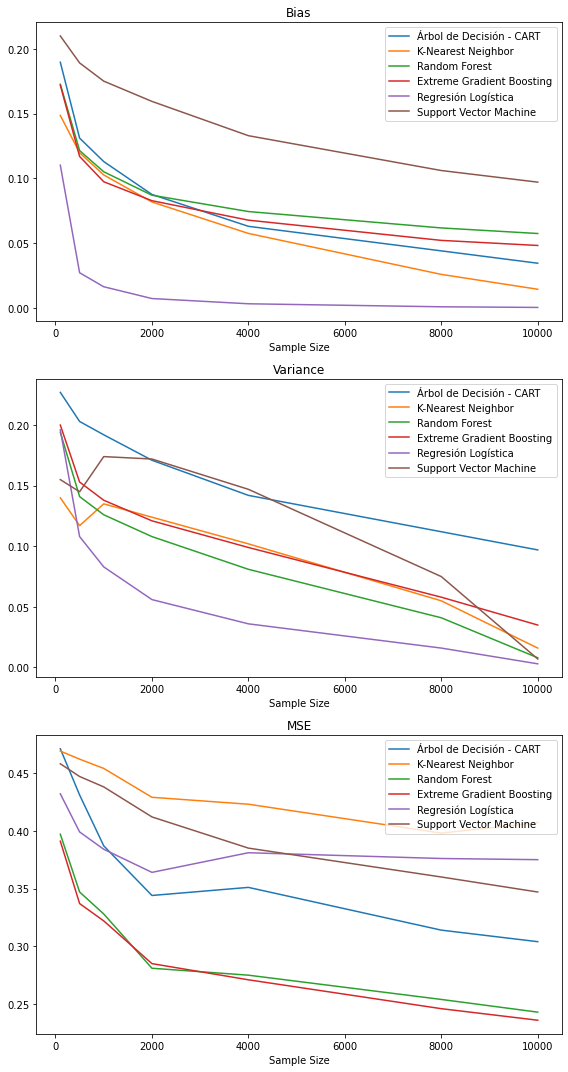

In [46]:
# Plotting the obtained results
fig = plt.figure(figsize=(8,15))
layout = (3, 1)

ax0 = plt.subplot2grid(layout, (0, 0))
ax0.title.set_text('Bias')

temp = bias_variance_result[bias_variance_result['algorithm'] == 'Decision Tree']
ax0.plot(temp.sample_count, temp.bias)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'KNN']
ax0.plot(temp.sample_count, temp.bias)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'Random Forest']
ax0.plot(temp.sample_count, temp.bias)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'XGBoost']
ax0.plot(temp.sample_count, temp.bias)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'LogisticRegression']
ax0.plot(temp.sample_count, temp.bias)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'SVM']
ax0.plot(temp.sample_count, temp.bias)

ax0.legend(['Árbol de Decisión - CART','K-Nearest Neighbor','Random Forest','Extreme Gradient Boosting','Regresión Logística', 'Support Vector Machine'], loc=1)
ax0.set_xlabel('Sample Size')

ax1 = plt.subplot2grid(layout, (1, 0))
ax1.title.set_text('Variance')

temp = bias_variance_result[bias_variance_result['algorithm'] == 'Decision Tree']
ax1.plot(temp.sample_count, temp.variance)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'KNN']
ax1.plot(temp.sample_count, temp.variance)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'Random Forest']
ax1.plot(temp.sample_count, temp.variance)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'XGBoost']
ax1.plot(temp.sample_count, temp.variance)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'LogisticRegression']
ax1.plot(temp.sample_count, temp.variance)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'SVM']
ax1.plot(temp.sample_count, temp.variance)

ax1.legend(['Árbol de Decisión - CART','K-Nearest Neighbor','Random Forest','Extreme Gradient Boosting','Regresión Logística', 'Support Vector Machine'], loc=1)
ax1.set_xlabel('Sample Size')


ax2 = plt.subplot2grid(layout, (2, 0))
ax2.title.set_text('MSE')

temp = bias_variance_result[bias_variance_result['algorithm'] == 'Decision Tree']
ax2.plot(temp.sample_count, temp.mse)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'KNN']
ax2.plot(temp.sample_count, temp.mse)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'Random Forest']
ax2.plot(temp.sample_count, temp.mse)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'XGBoost']
ax2.plot(temp.sample_count, temp.mse)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'LogisticRegression']
ax2.plot(temp.sample_count, temp.mse)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'SVM']
ax2.plot(temp.sample_count, temp.mse)

ax2.legend(['Árbol de Decisión - CART','K-Nearest Neighbor','Random Forest','Extreme Gradient Boosting','Regresión Logística', 'Support Vector Machine'], loc=1)
ax2.set_xlabel('Sample Size')


plt.tight_layout()

In [43]:
bias_variance_result[bias_variance_result['sample_count'] == 8000]

,sample_count,no_of_models,algorithm,bias,variance,mse
30,8000,20,Decision Tree,0.044130,0.112,0.314
31,8000,20,KNN,0.025992,0.055,0.398
32,8000,20,Random Forest,0.061818,0.041,0.254
33,8000,20,XGBoost,0.052216,0.058,0.246
34,8000,20,LogisticRegression,0.001013,0.016,0.376
35,8000,20,SVM,0.106089,0.075,0.360


<b>Observations</b><br>
1) Linear Regression has the least Bias which is not as expected. This hints us that the data is more suited for Linear Regression. <br>
2) Variance : Linear Regression < Random Forest < Bagging < Decision Tree, which is as expected.<br>
3) Bias : Random Forest < Bagging < Decision Tree, which is also as expected.<br>
4) It could be observed that the increase in the sample size aids in decrease in Bias and Variance. But often it is quite expensive to obtain data with higher sample size. So, increasing the sample size might not be a viable solution for reducing bias and variance of the model.

<b>Observations: </b> <br>
1) Observing  changes in Bias and Variance with various values of alpha for a sample of 1000.<br>
2) Visually enables us to view the bias and variance trade of  point. In ideal scenario, the alpha value is a tuning parameter i.e. model is trained with various values of alpha and cross validation scores is recorded and the alpha which gives us the best score is selected for the best model.<br>
3) As per the figure below, it can be observed that with the increase in the value of alpha, bias value increases and the variance decreases.<br>

Bias and variance calculation are done based on the below citation

Markgraf, Bert. "How to Calculate Bias" sciencing.com, https://sciencing.com/how-to-calculate-bias-13710241.html. 8 September 2020.